<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn  as sns
from sklearn.metrics.scorer import make_scorer
import re
from IPython.display import HTML, display
from tqdm.auto import tqdm
from sklearn.pipeline import Pipeline
import time
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
#параметры
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 300

#Параметры для отладки
DEBUGING = False               #вывод на экран текущих параметров

models_params_find = False

R_STATE = 737
N_JOBS = -1  
filled_VehicleType=False

MODEL_TEXT_NAME = {'LinearReg':'Линейная регрессия'
                    ,'DecTreeReg':'Дерево принятия решений для регрессии' 
                    ,'RndForestReg':'Случайный лес для регрессии'
                    ,'DecTreeCls':'Дерево принятия решений для классификации' 
                    ,'RndForestCls':'Случайный лес для классификации'
                    ,'LGBMReg':'Ансамбль LightGBM для регрессии'}

In [3]:
def disp_font_size(text,font_size=3):
    display(HTML(f"<font size='{font_size}'>{text}</font>"))
def info_print (data, title, column='', bins=20, unit=''
                , prntInfo=True, prntGraph=True, prnt_smpl=True
               , returnMetric=False, drop_out=False):
    '''
    функция для отоброжения информации о наборе данных
    '''
    div = ''.join(['=' for i in range(1,len(title))])
    print(div)
    print('\n',title,'\n')
    print(div)
    if prntInfo:        
        data.info()
        print(div)
        print(f'Количество дубликатов: {data.duplicated().sum()}')
        print(div)
        if data.duplicated().sum() > 0:
            try:
                print(f'Пример дубликатов:')
                display(data.loc[data.duplicated(keep=False)].sort_values(by=data.columns[1]).head())            
                print(div)
            except: None    
        if prnt_smpl:
            print(f'Пример первых 5 записей:')
            display(data.head())             
            print(div)
     
    if column != '':
        data_prin = data[column]
    else:
        data_prin = data
        
    if prntGraph:        
        #try:
            std_dev = np.std(data_prin) #Стандартное распределение
            mu = data_prin.mean() #среднее значение 
            sigma3_min = mu - 3*std_dev
            sigma3_max = mu + 3*std_dev
            print(f'Среднее: {round(mu,2)} \n')
            print(f'Стандартное отклонение: {round(std_dev,2)} \n')
            print(f'Доверительный интервал: от {round(sigma3_min,2)} до {round(sigma3_max,2)} \n')    
            print(f'Минимум: {round(data_prin.min(),4)} Максимум: {round(data_prin.max(),4)} \n')    
            fig, ax = plt.subplots(1,2,figsize=(17, 3))
            fig.suptitle(title) 
            sns.boxplot(data_prin, ax=ax[0])
         
            sns.distplot(data_prin, ax=ax[1],bins=bins)              
            #границы по правилам трёх сигм
            plt.axvline(sigma3_min,color='r',linestyle='--') 
            plt.axvline(sigma3_max,color='r',linestyle='--')
            ax[0].set_xlabel(unit, fontsize=15, color='black')            
            ax[1].set_xlabel(unit, fontsize=15, color='black')
            plt.show()      
            if returnMetric:
                if drop_out: 
                    mu = data_prin.loc[(sigma3_min < data_prin) & (data_prin < sigma3_max)].mean()
                    print(f'Среднее без учёта выбросов: {round(mu,2)} \n')                    
                return mu, std_dev
            
        #except: None

In [4]:
try:
    taxi = pd.read_csv('/datasets/taxi.csv')
except:
    taxi = pd.read_csv('taxi.csv')
display(taxi.info())
display(taxi.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28


In [5]:
taxi['datetime'] = taxi['datetime'].astype('datetime64')
taxi.set_index('datetime',inplace=True)
taxi.sort_index(inplace=True)
taxi_day = taxi.resample('1D').sum()
taxi = taxi.resample('1h').sum()
display(taxi.head(3))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'><br>ОК, данные на базе)

## Анализ

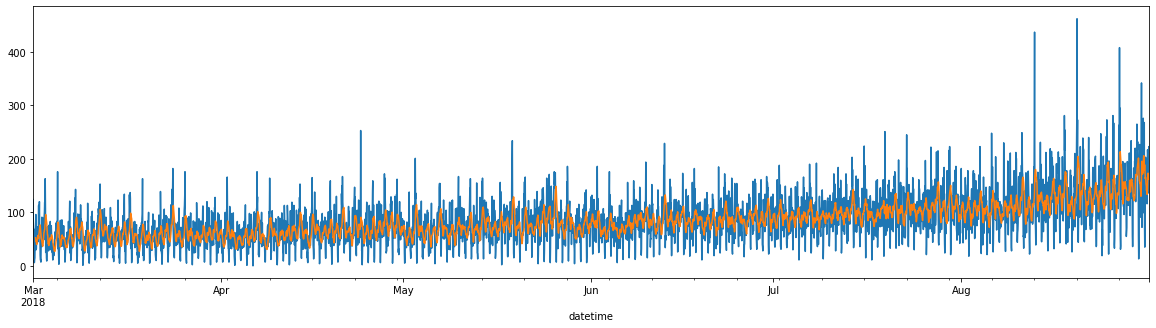

In [6]:
ax = taxi['num_orders'].plot(figsize=(20, 5))
taxi['num_orders'].shift().rolling(10).mean().plot(figsize=(20, 5),ax=ax)

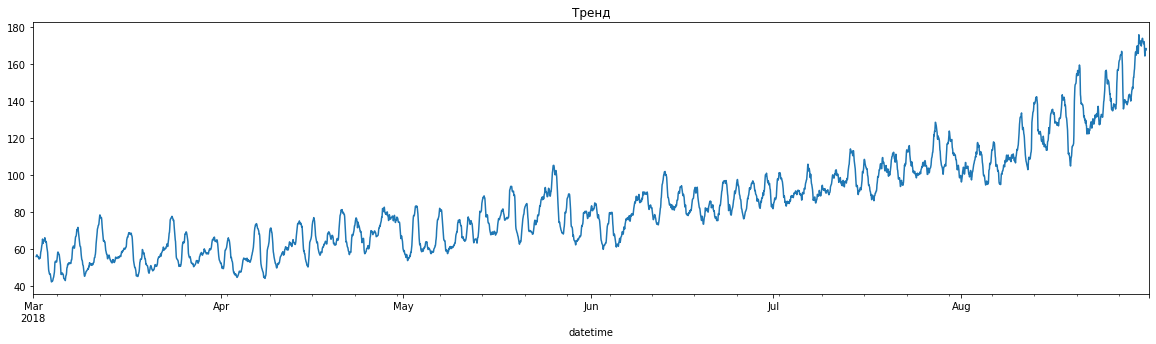

In [7]:
decomposed = seasonal_decompose(taxi['num_orders'])

decomposed.trend.plot(figsize=(20, 5),title='Тренд') 

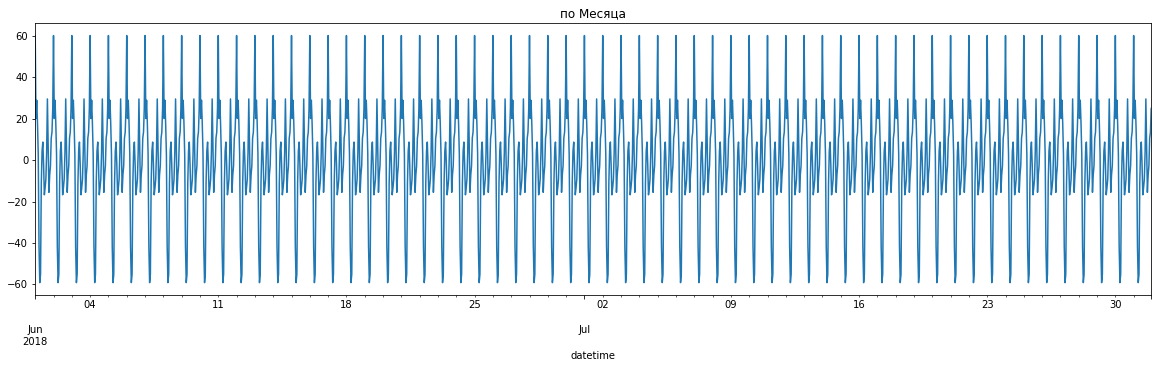

In [8]:
decomposed.seasonal['2018-06':'2018-07'].plot(figsize=(20, 5),title='по Месяца')

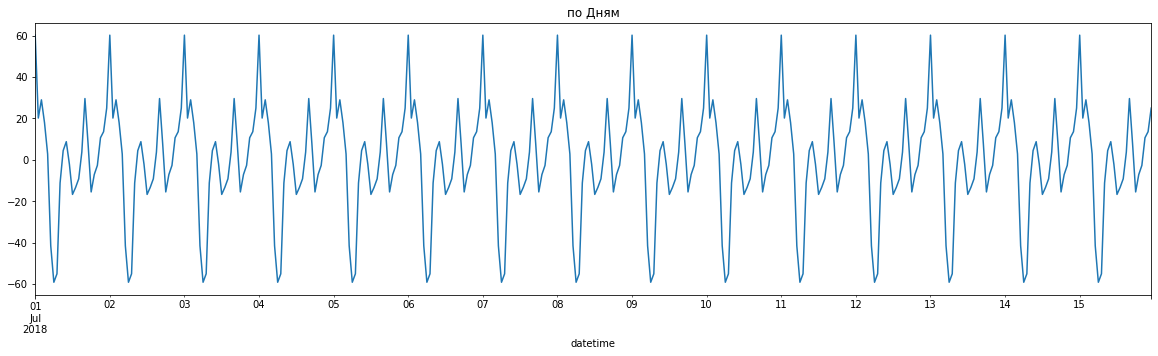

In [9]:
decomposed.seasonal['2018-07-01':'2018-07-15'].plot(figsize=(20, 5),title='по Дням')

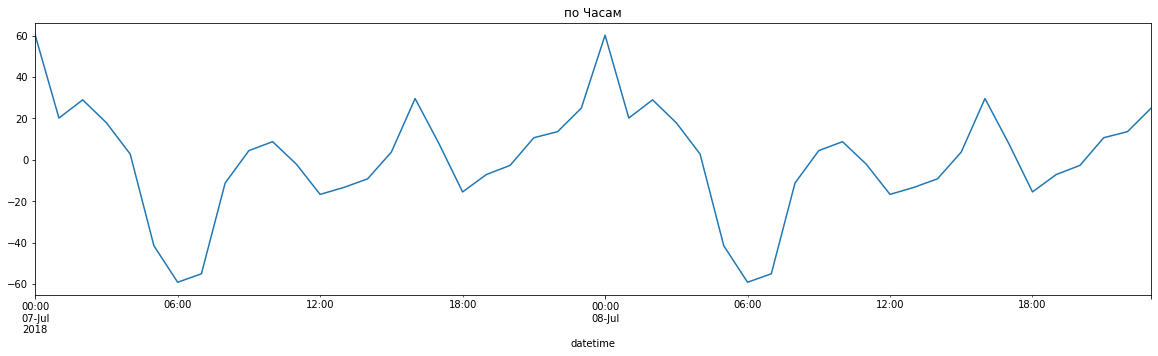

In [10]:
decomposed.seasonal['2018-07-07 00:00:00':'2018-07-08 23:59:59'].plot(figsize=(20, 5),title='по Часам')


 num_orders 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 229.0 KB
Количество дубликатов: 4165
Пример дубликатов:
Среднее: 84.42 

Стандартное отклонение: 45.02 

Доверительный интервал: от -50.63 до 219.48 

Минимум: 0 Максимум: 462 



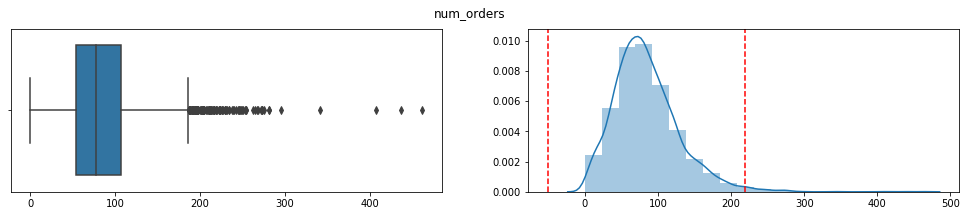

In [11]:
info_print (taxi, 'num_orders', column='num_orders', bins=20, unit=''
                , prntInfo=True, prntGraph=True, prnt_smpl=False)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
Исследование - понятно.<font color='red'><br> График сезонности хорошо бы изучить ещё методом декмпозиции, напрмиер. Сделай, пожалуйста<br><font color='green'><br>
Инструмент декомпозиции в частности, а графический анализ временных рядов как в принципе - важный этап моделирования рядов.<br> Позволяет увидеть продажи визуально, а это помогает сделать предвариетльные выводы<br>
    
Хочу озвучить ещё такой момент<br>
Дело в том, в реальности бизнеса есть все три вида сезонности:<br>
1) дневная сезонность есть - ведь данные собраны по дням, т.е. будни и выходные имеют разные продажи<br>
2) внутрисуточная сезонность: когда продажи утром отличаются от продаж вечером <br>
3) месячная сезонность: когда продажи лета и осени - разные.<br><br>
И если строить прогноз на длительный период времени, то без учёта всех видов сезонности  - не обойтись<br>
Например: есть в данных восходящий тренд. Но вопрос такой возникает: <br>
этот подъём действительно за счёт роста компании (чаще всего тренд - это отражение роста компании) или есть ещё влияние месячной сезнности? (летом - продаж в рост, например, и именно этот момент мы наблюдаем в данных)<br>
Ответ на вопрос - не протой на имеющихся данных - у нас данных меньше года. А это означает, что месячную сезонность нам не просто вычислить адекватно - т.е. не внести в модель корректтировки месяцев(<br>
Поэтому, я бы дал такой совет:<br>
на горизонте прогнозирования - несколько часов или дней - можно предположить что у нас тренд.<br>
А если строить прогноз на несколько недель - вот тут утверждать наличие тренда надо с большой осторожностью))))<br><br>
Ну, а если вернуться к постановке задаче - построить прогноз на час (очень маленький горизонт), то двух сезонности может и хватить.
    
<font color='blue'><br>  
Сделал насколько понял.
<br> к моему удивлению не увидел разницы для выходных и будних дней.
</font>         

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>Отлично!<br>Тут, что бы увидеть недельную сезонность (дня недели) можно пойти двумя путями:<br>
1)Взять часовые данные за длительный период. Но на экране сложно будет увидеть...<br>
2) агрегировать(суммировать) часовые данные за день.  И тогда ещё раз построить декомппозицию - будет видно)<br>

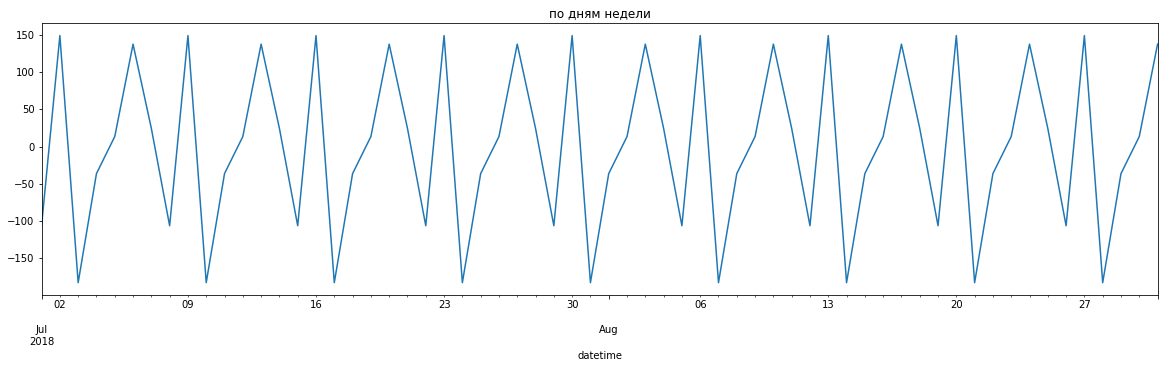

In [12]:
decomp_day = seasonal_decompose(taxi_day['num_orders'])
decomp_day.seasonal['2018-07':'2018-08'].plot(figsize=(20, 5),title='по дням недели')

## Обучение

In [13]:
def rmse(test,pred):
    return round(np.sqrt(mean_squared_error(test,pred)),4)

def display_metric(score, scorer, title=''): 
    """
    Функция для вывода метрик
    """                   
    scorer_name = re.sub(r".*\(|\,.*|\)", '', str(scorer))

    disp_font_size(f" {title} {scorer_name.upper()}: = {score}",5)    

In [14]:
def score_cv(model, features, target, scorer, cv=5, mean=True):
    el_time = time.time()
    result = cross_val_score(model, features, target, scoring=scorer, cv=TimeSeriesSplit(n_splits=2), n_jobs=N_JOBS) 
    el_time = round(time.time() - el_time,2)
    if mean: result = round(result.mean(),4)
    return result, el_time 

def  make_pipe(model, **kwargs):
    return Pipeline([
    #('scale', StandardScaler()),
    ('clf', model)
])
def make_clf(model_type, **kwargs):
    if model_type == 'RndForestReg':
        model = make_pipe(RandomForestRegressor(random_state=R_STATE, **kwargs))
    elif model_type == 'DecTreeReg':        
        model = make_pipe(DecisionTreeRegressor(random_state=R_STATE, **kwargs))
    elif model_type == 'LinearReg':
        model = make_pipe(LinearRegression(**kwargs))
    elif model_type == 'RndForestCls':
        model = make_pipe(RandomForestClassifier(random_state=R_STATE, **kwargs))
    elif model_type == 'DecTreeCls':        
        model = make_pipe(DecisionTreeClassifier(random_state=R_STATE, **kwargs))
    elif model_type == 'LGBMReg':
        model = make_pipe(LGBMRegressor(boosting_type='gbdt',random_state=R_STATE, **kwargs))       
    else: return 0, 'Тип модели не найден'
    return model

#Таблица для хранения лучших результатов моделей
columns_model = ['model','g_param','Score']
models_valid = pd.DataFrame(columns=columns_model)    

In [15]:
def get_model(params, train_features, train_target):    
    model = make_clf(params['model'], **params['g_param'])
    pbar = tqdm(total = 1)
    model.fit(train_features, train_target)   
    pbar.update(1)    
    pbar.close()        
    return model


def get_param_list(kwargs):
    params_list = pd.DataFrame()    
    if len(kwargs) > 0:        
        new_str = pd.Series()
        for key, param in kwargs.items():
            old_param_list = params_list.copy()
            params_list = pd.DataFrame()
            num_params = len(old_param_list)
            if num_params < 1 : num_params=1
            for str_ind in range(num_params):
                try:
                    for p in param:
                        try:
                            new_str = old_param_list.iloc[str_ind]
                        except: None
                        new_str[key] = p
                        params_list = params_list.append(new_str, ignore_index=True)                    
                except:
                    params_list[key] = param       
    if len(params_list) < 1: params_list.loc[0,'no_param']='no_param'
    return params_list

    
def get_model_params(model_type, features, target, scorer, title=''
                 , disp_metr=True
                 ,returnModel=False, debug=False, **kwargs):

    """
    Функция для создания модели  
    
    """
    
    columns_model = ['model','g_param','el_time','score']
    models_param = pd.DataFrame(columns=columns_model)    

       
    print('==========================')    
    disp_font_size(f"Модель: {MODEL_TEXT_NAME[model_type]} {title} <br>",5)
    
    params_list = get_param_list(kwargs)

    pbar = tqdm(total = len(params_list))
    params = {}
    for ind, row in params_list.iterrows():
        for col_n, val in row.items():
            if col_n != 'no_param':
                if float(val)%1>0: params[col_n] = float(val)
                else: params[col_n] = int(val)      
        model = make_clf(model_type, **params)  
        try:
            score, el_time = score_cv(model, features, target, scorer)            
            if debug: print(f'{kwargs}|{score}')              
            models_param = models_param.append({'model': model_type
                                               ,'g_param':{**params}                                                
                                               ,'el_time':el_time
                                               ,'score':score}
                                               , ignore_index=True)   
        except:
            models_param = models_param.append({'model': model_type
                                               ,'g_param':{**params}                                                
                                               ,'el_time':'Err'
                                               ,'score':'Err'}
                                               , ignore_index=True)   
        pbar.update(1)      
    pbar.close()        
    #Вывод результатов    
    models_param = models_param.loc[~models_param['score'].isin(['Err','-'] )]
    models_param = models_param.sort_values(by='score', ascending=False).reset_index(drop=True)
 
    
    if disp_metr: 
        display(models_param)
        disp_font_size(re.sub(r'[\{\}]', '', str(models_param.loc[0,'g_param'])),5)
        disp_font_size(f"Время: {models_param.loc[0,'el_time']}",5)
        display_metric(models_param.loc[0,'score'], scorer)             
        
  
    return models_param

def models_test(params, features, target, test_features, test_target, scorer):
    models_p = pd.DataFrame(columns=['model','g_param','test_time','test_score'])    
    tested_model = pd.DataFrame()
    for i, row in params.iterrows():
        el_time = time.time()
        try:
            model = get_model(row, features, target)    
            predict = model.predict(test_features)
            score = round(scorer(test_target,predict)) * -1
        except:
            score = 'Err'
        el_time = round(time.time() - el_time,2)
        disp_font_size(MODEL_TEXT_NAME[row['model']],5)  
        disp_font_size(re.sub(r'[\{\}]', '', str(row['g_param'])),4)  
        display_metric(score, '', title='Тестовая выборка')
        tested_model = row[['model','g_param']]
        tested_model['test_score'] = score
        tested_model['test_time'] = el_time
        models_p = models_p.append(tested_model, ignore_index=True) 
    return models_p.sort_values(by='test_score', ascending=True).reset_index(drop=True)
        
def models_serch(params, features, target, test_features=None, test_target=None, scorer=[rmse,False]
                 , test=False, test_num=1):
    models_p = pd.DataFrame()   
    
    my_scorer = make_scorer(scorer[0], greater_is_better=scorer[1])  
    for model, params in params.items():
        model_name = re.sub(r".*\_", '', str(model))    
        log = get_model_params(model_name, features, target, my_scorer, disp_metr=True, **params, debug=DEBUGING)
        sort_column = 'score'
        test_num_str = test_num
        log['test_time'] = '-'
        log['test_score'] = '-' 
        if test:
            print('======================')
            disp_font_size("Результаты на тестовой выборке",5)  
            if test_num < len(log): test_num_str = test_num
            else: test_num_str = len(log)
            models_test_p = models_test(log.head(test_num_str+1), features, target, test_features, test_target
                                            , scorer=scorer[0])
            display(models_test_p)                
          
            log.loc[0:test_num,'test_time'] = models_test_p.loc[0:test_num,'test_time']
            log.loc[0:test_num,'test_score'] = models_test_p.loc[0:test_num,'test_score']
            sort_column = 'test_score'      
            
        models_p = models_p.append(log, ignore_index=True,sort=False)   
    result = models_p.loc[~models_p[sort_column].isin(['Err','-'] )]
    return  result.sort_values(by=sort_column, ascending=False).reset_index(drop=True)

def div_features_target(df,targetname):
    """
    Функция для разделения таблицы на признаки и целевой признак
    """
    return df.drop([targetname], axis=1), df[targetname]

In [16]:
def make_features(data, max_lag=6, rolling_mean_size=10):
#    data['year'] = data.index.year
#    data['month'] = data.index.month
#data['month_day'] = f"{data.index.month}_{data.index.day}"
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
params_find = False
  
if params_find:
    params_s ={'max_lag': range(15,32,1), 'rolling_mean_size': range(24,169,24)}            
    ft_params_list = get_param_list(params_s)    
    ft_params_score = pd.DataFrame(columns=['g_param','train_score','test_score']) 
    model = LinearRegression()
    params = {}
    pbar = tqdm(total = len(ft_params_list))
    for ind, row in ft_params_list.iterrows():
        taxi_copy = taxi.copy()
        for col_n, val in row.items():
            if col_n != 'no_param':
                if float(val)%1>0: params[col_n] = float(val)
                else: params[col_n] = int(val)
        
        make_features(taxi_copy, **params)
        
        train, test = train_test_split(taxi_copy, shuffle=False, test_size=0.1)
        train = train.dropna()

        train_features, train_target = div_features_target(train,'num_orders')
        test_features, test_target = div_features_target(test, 'num_orders')
        
        model.fit(train_features, train_target)
        train_pred = model.predict(train_features)
        test_pred = model.predict(test_features)

        ft_params_score = ft_params_score.append({'g_param':{**params},
                                                  'train_score':rmse(train_target,train_pred),
                                                  'test_score':rmse(test_target,test_pred)},
                                                   ignore_index=True) 
        pbar.update(1)
    pbar.close
    ft_params_score = ft_params_score.sort_values(by='test_score', ascending=True).reset_index(drop=True)        
else:    
    ft_params_score = pd.DataFrame({
                                   'g_param':[{'max_lag': 31, 'rolling_mean_size': 72},
                                                {'max_lag': 2, 'rolling_mean_size': 72},
                                                {'max_lag': 99, 'rolling_mean_size': 24}
                                               ],
                                   'train_score':[25, 30, 22],   
                                   'test_score':[44, 49, 39]
                                   })    

In [18]:
display(ft_params_score)

,g_param,train_score,test_score
0,"{'max_lag': 31, 'rolling_mean_size': 72}",25,44
1,"{'max_lag': 2, 'rolling_mean_size': 72}",30,49
2,"{'max_lag': 99, 'rolling_mean_size': 24}",22,39


In [19]:
make_features(taxi, **ft_params_score.loc[0,'g_param'])

train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()

train_features, train_target = div_features_target(train,'num_orders')

test_features, test_target = div_features_target(test, 'num_orders')

### Проверка на адекватность

In [20]:
print("Cреднее количество заказов такси в час:", round(test['num_orders'].mean(),4))
print("Все значения тестовой выборки предсказываются одним и тем же числом (константой):")
pred_median = np.ones(test.shape) * train['num_orders'].median()
print("RMSE:", rmse(test,pred_median))
print("Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1):")
pred_previous = test.shift()
pred_previous.iloc[0] = train['num_orders'].iloc[-1]
print("RMSE:", rmse(test,pred_previous))

Cреднее количество заказов такси в час: 139.5566
Все значения тестовой выборки предсказываются одним и тем же числом (константой):
RMSE: 85.1621
Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1):
RMSE: 56.7229


In [21]:
models_params_find = False
  
if models_params_find:
    models_param = {
            'LinearReg':{},
            'DecTreeReg':{ 'max_depth': range(10,12,1)},
            'RndForestReg':{'max_depth': range(10,12,1), 'n_estimators': range(39,41,1)},
            'LGBMReg':{'max_depth': range(5,6,1),'n_estimators': range(855,858,1), 
                          'learning_rate':[0.01]}
            }            
    
    model_list = models_serch(models_param, train_features, train_target
                                          , test_features,  test_target
                                          , test=True, test_num=1)
else:    
    model_list = pd.DataFrame({'model' : ['LGBMReg','RndForestReg','LinearReg'],
                                        'g_param' : [{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 856},                                                     
                                                     {'max_depth': 10, 'n_estimators': 39},
                                                    {}],
                                        'el_time' : [12.7, 2.4, 0.43],   
                                        'score' : [-27, -27, -27],
                                        'test_time' : [8.7, 2.3, 0.22],   
                                        'test_score' : [-43, -44, -44]}
                                      )

In [22]:
display(model_list)

,model,g_param,el_time,score,test_time,test_score
0,LGBMReg,"{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 856}",12.70,-27,8.70,-43
1,RndForestReg,"{'max_depth': 10, 'n_estimators': 39}",2.40,-27,2.30,-44
2,LinearReg,{},0.43,-27,0.22,-44


In [23]:
def check_model_predict(model_param, train_features, train_target, test_features, test_target):
    model_01 = get_model(model_param, train_features, train_target)
    day_test_pred = model_01.predict(test_features)
    day_test_target_pred = pd.DataFrame()
    day_test_target_pred['target'] = test_target
    day_test_target_pred['pred'] = day_test_pred
    ax = day_test_target_pred['target'].plot(figsize=(20, 5), label='target', title=model_param['model'])
    day_test_target_pred['pred'].plot(figsize=(20, 5),ax=ax, label='prediction')
    plt.legend()
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

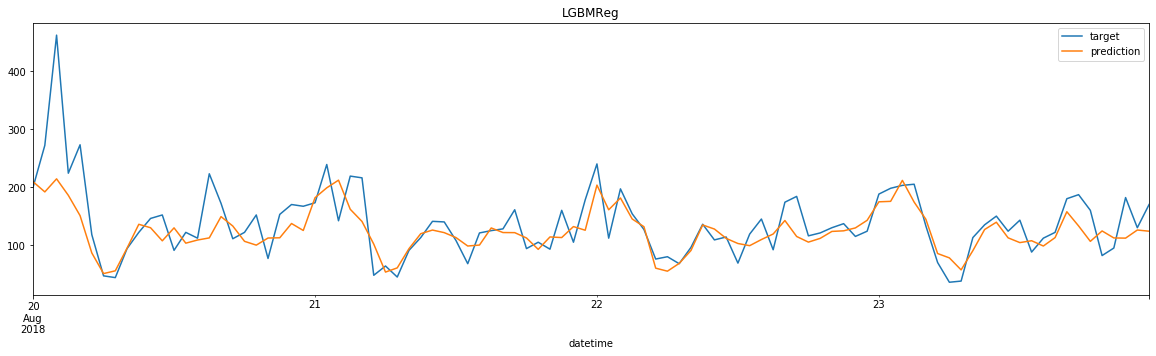

  0%|          | 0/1 [00:00<?, ?it/s]

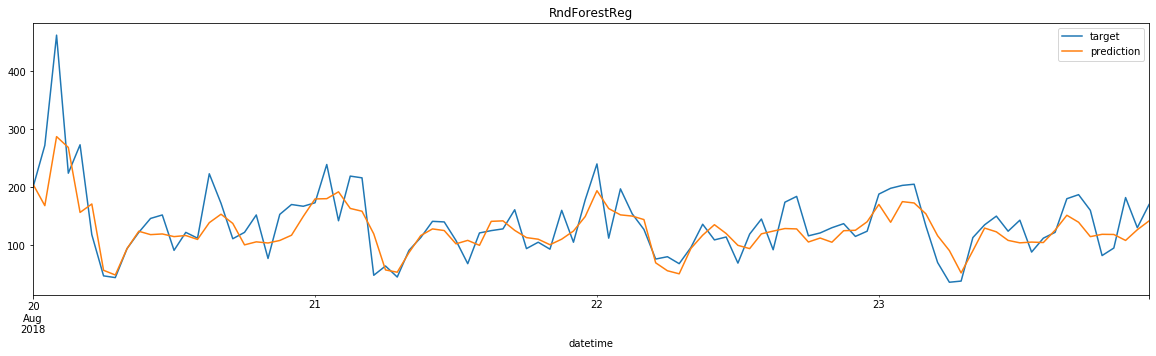

  0%|          | 0/1 [00:00<?, ?it/s]

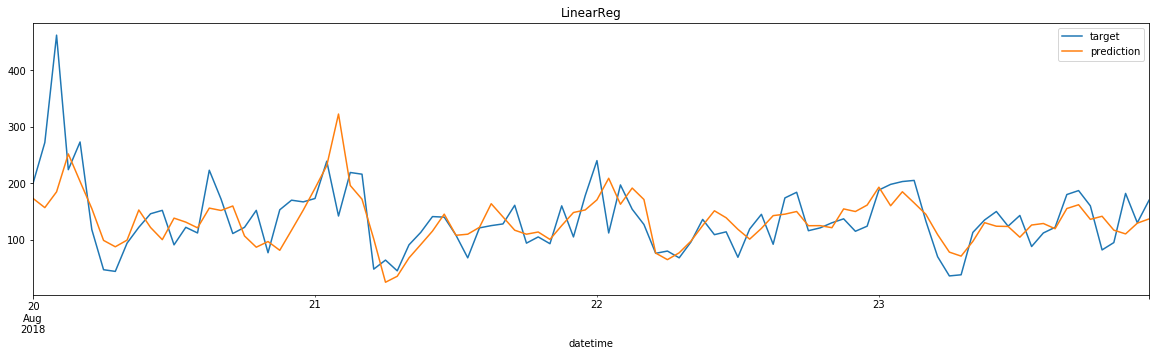

In [24]:
for i in range(len(model_list)):
    check_model_predict(model_list.loc[i], train_features, train_target
                    , test_features['2018-08-20':'2018-08-23']
                    , test_target['2018-08-20':'2018-08-23'])

### Вывод
Большое значения для конечной метрики играют созданные признаки и определение закономерностей временного ряда, а не выбор моделей!
Судя по графику модель случайного леса точнее предсказывает резкие перепады и точки максимума.